In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# Cause plots to be displayed in the notebook:
%matplotlib inline
from energy_functions import twoD_Gaussian,coupled_oscillator_energy_force
from energy_functions import  doubleWellPot as dw
from optimize_functions import local_minimization,perturb_coordinates,acceptance_probability,basin_hopping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from parallel_temper1D import parallel_temper as pt

In [58]:
def bin_centers(bin_edges):
    return (bin_edges[1:]+bin_edges[:-1])/2.

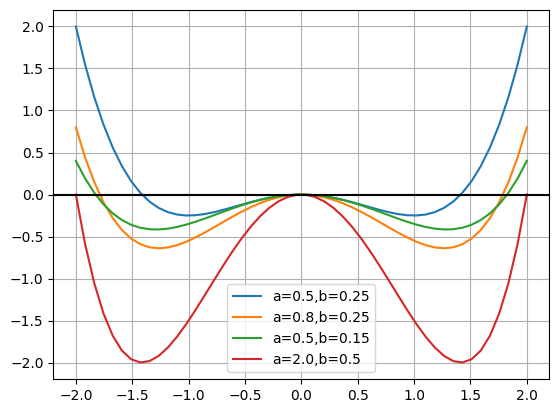

In [59]:
xp=np.linspace(-2,2)
plt.plot(xp,dw(xp,a=0.5,b=0.25),label="a=0.5,b=0.25")
plt.plot(xp,dw(xp,a=0.8,b=0.25),label="a=0.8,b=0.25")
plt.plot(xp,dw(xp,a=0.5,b=0.15),label="a=0.5,b=0.15")
plt.plot(xp,dw(xp,a=2.0,b=0.5),label="a=2.0,b=0.5")
plt.axhline(0.0,c='k')
plt.grid()
plt.legend()

step: 200 Temp: 0.010 acc1: 0.245 acc2: 0.275 rej: 0.485 maxdr: 0.428 dev: 0.006
step: 200 Temp: 0.050 acc1: 0.275 acc2: 0.255 rej: 0.475 maxdr: 0.965 dev: 0.024
step: 200 Temp: 0.100 acc1: 0.235 acc2: 0.230 rej: 0.540 maxdr: 3.921 dev: -0.157
step: 200 Temp: 1.000 acc1: 0.230 acc2: 0.245 rej: 0.530 maxdr: 13.052 dev: -0.392
step: 400 Temp: 0.010 acc1: 0.228 acc2: 0.240 rej: 0.535 maxdr: 0.402 dev: -0.014
step: 400 Temp: 0.050 acc1: 0.265 acc2: 0.240 rej: 0.497 maxdr: 0.514 dev: 0.001
step: 400 Temp: 0.100 acc1: 0.258 acc2: 0.275 rej: 0.470 maxdr: 1.773 dev: 0.053
step: 400 Temp: 1.000 acc1: 0.247 acc2: 0.280 rej: 0.475 maxdr: 9.989 dev: 0.250
step: 600 Temp: 0.010 acc1: 0.250 acc2: 0.262 rej: 0.490 maxdr: 0.591 dev: 0.006
step: 600 Temp: 0.050 acc1: 0.252 acc2: 0.228 rej: 0.522 maxdr: 1.127 dev: -0.024
step: 600 Temp: 0.100 acc1: 0.243 acc2: 0.257 rej: 0.502 maxdr: 3.213 dev: -0.005
step: 600 Temp: 1.000 acc1: 0.235 acc2: 0.255 rej: 0.512 maxdr: 3.223 dev: -0.038
step: 800 Temp: 0.010

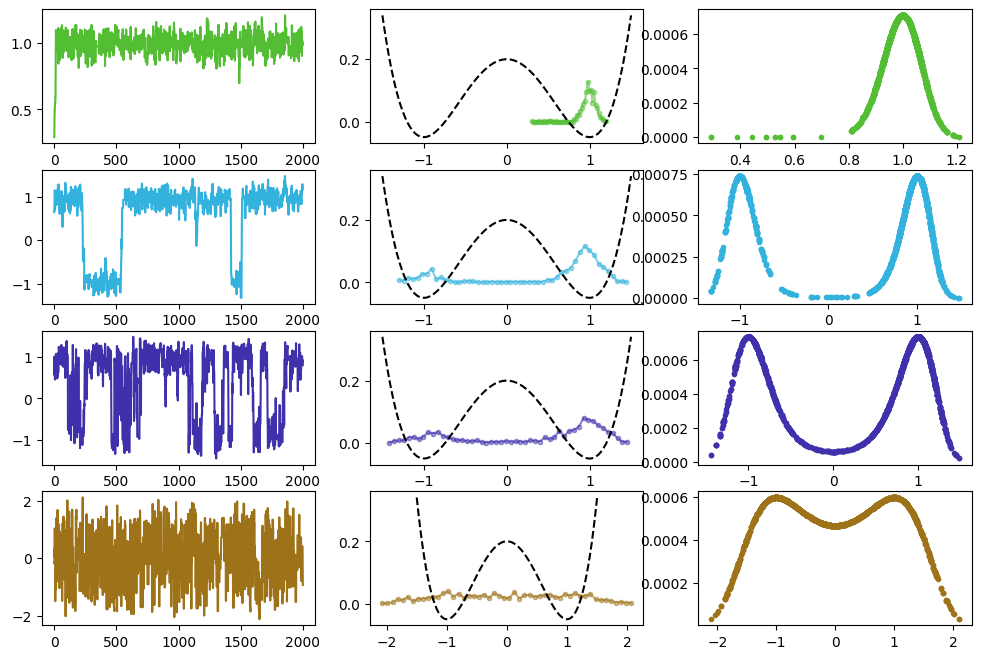

In [60]:
# Set the initial state of all replicas
nrep = 4  # Number of replicas
dim = 1   # this is a 1D potiental - the pt algoritham is modified to handle multidimensional PES
          # but for special case of 1D we need to modify the inputs and outputs for processing 
x=np.zeros((nrep))
for rep in range(nrep):
    x[rep] = np.random.rand()-0.5              # initial x position of each replice

# Set simulation parameters

nsteps = 2000     # Number of MC sweeps 10000
refreq =  0.0 # 0.001       # 0.5 Fraction of the time to attempt replica exchange
# Temp = np.array([0.01,0.05,0.1,1.0])     # Temperature at each replica

# actually the relation between temperatures is beta1-beta2 = dbeta 
# the idea is to keep dbeta = constant  
# eg. betas=linspace(0,10,11)  # beta=1/kB*T  set kB=1.0      
#  so   temps=1/(betas+1)
# array([0.09090909, 0.13043478, 0.23076923, 1.        ])

betas=np.linspace(40,0,4)  # large beta is cold 
# Temp = 1/(betas+1)          # this will make the temps equally spaced in terms of beta  
# slight manual adjustment  beacue we dont have many baths
Temp=np.array([0.01,0.05,0.1,1.0])

# maxdr = np.array([0.5, 1.5, 3.0, 6.0])     # Maximal displacement in each MC step, for each replica
maxdr = np.array([1.0, 1.0, 1.0, 1.0])     # Maximal displacement in each MC step, for each replica

# equally spaced temps may not be ideal. lets try 
# Temp=-1/(np.log(np.linspace(0.001,0.5,4)))   
# Temp=np.array([0.01,0.1,0.2,1.0])
# Temp= -1/(np.log(np.linspace(0.0000001,0.4,4)))
# maxdr = np.array([0.5, 1.5, 3.0, 6.0])     # Maximal displacement in each MC step, for each replica

# print(dw(x))

xTraj = pt(dw,x,nrep,nsteps,refreq,Temp,maxdr)

print("means:", [np.mean(xTraj[rep]) for rep in range(nrep)])
print("variance:", [np.var(xTraj[rep]) for rep in range(nrep)])

hists=[]
edges=[]
boltzs=[]
for rep in range(nrep):
    x_hist, x_bin_edges = np.histogram(xTraj[rep],bins=50,density=False)  # these are the real the simualted distributions

 # Calculate the system's true boltzmann distribution
    # dw(x) = -kT.log(boltz)
    # -(dw(x)/kT) = log(boltz)
    
    boltz = np.exp( -dw(xTraj[rep])/Temp[rep])
    boltz = boltz/(np.sum(boltz)) #Normalize
    hists.append(x_hist)
    edges.append(x_bin_edges)
    boltzs.append(boltz) 
    X=np.linspace(-1.5,1.5,100)
    Y=dw(X)+0.2

rgb=np.random.uniform(size=(nrep,3))
fig, axes = plt.subplots(nrep,3, figsize=(12,8))
for rep in range(nrep):
    axes[rep,0].plot(xTraj[rep],linestyle='-',color=(rgb[rep]))    # low temp bath 
    axes[rep,1].plot(bin_centers(edges[rep]),hists[rep]/float(nsteps),linestyle='-',color=(rgb[rep]),marker='.',alpha=0.6,markerfacecolor='none',markeredgewidth=1.5,markersize=5,label='x%i'%rep )
    axes[rep,1].plot(X,Y,'--k')
    axes[rep,2].plot(xTraj[rep],boltzs[rep],'.',color=(rgb[rep]))    # low temp bath 
plt.show()


From this i would suggest leaving the temperatures alone. 
The variance becomes the same when exchange is turned on.
adjust shifts for a long time in MC mode to try get the aceptance ratio we want.  
the spring can also be adjusted to get a specifict variance at a given temperatrue.
I would just run a few 1000 steps without exchange to get the shift as close as possible. then manually drop the learning rate 
unitl the acepance ratio appear  stable . then tun on exchange and sample. 
I would also weight the spring so the variance is behaving itself. 
you may have to check its working for each space group.


In [13]:
# create local minima

np.random.seed(42)

nlocalminima=100
amps=np.zeros((nlocalminima))
offsets=np.zeros((nlocalminima))
xy0=np.zeros((nlocalminima,2))
sigma_xy=np.zeros((nlocalminima,2))
thetas=np.zeros((nlocalminima))


for i in range(nlocalminima):
    amps[i]=-10*np.abs(np.random.randn())
    offsets[i]=0 #-1*np.abs(np.random.randn())
    xy0[i,:]=4*np.random.rand(2)-2
    sigma_xy[i,:]=0.1*np.random.rand(2)
    thetas[i]=np.pi*np.random.randn()

In [82]:
# redefine energy function so it takes in x,y as a vector 
def pes(x1,nlocalminima=nlocalminima,amps=amps,offsets=offsets,xy0=xy0,sigma_xy=sigma_xy,thetas=thetas,**kwargs):
    x,y=x1
    ene1,_,_=coupled_oscillator_energy_force(x,y,d0=0.3,a=1.0,k=2.2,lamb=1.978)
    nx=0
    for i in range(nlocalminima):
        xo,yo=xy0[i,:]
        sigma_x,sigma_y=sigma_xy[i,:]
        nx=nx+twoD_Gaussian(x, y, amps[i], xo, yo, sigma_x, sigma_y, thetas[i], offsets[i])
    return ene1+nx

(2, 100, 100)
<class 'numpy.ndarray'>


<a list of 115 text.Text objects>

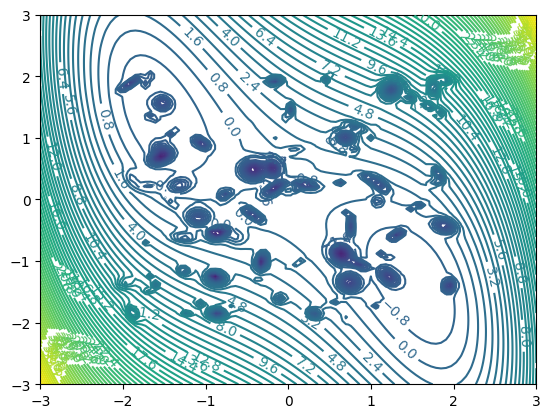

In [83]:
xmin,xmax=-3,3
x_points = np.linspace(xmin,xmax,100)
y_points = np.linspace(xmin,xmax,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=100)
plt.clabel(CS, inline=1, fontsize=10)

In [84]:
# X0=4*np.random.rand(2)-2
# X0=np.array([0.2,-1.2])
# Set the initial state of all replicas
nrep = 2                           # Number of replicas
dim = 2                            # Number of dimensions 
X0=np.zeros((dim,nrep))            # rows are the x,y coords in each column replica - capatibility for the way we setup pes
for rep in range(nrep):
    X0[:,rep] = 4*np.random.rand(dim)-2.0              # initial x position of each replice

# X0=np.array([[1.5,1.0],[1.5,1.0]]) # initial positions on the surface for two baths
print(type(X0))
print(pes(X0))
print(pes(X0[:,0]))
print(pes(X0[:,1]))
print(pes(X0))

<class 'numpy.ndarray'>
[ 0.71448609 -1.40919421]
0.71448609023068
-1.4091942092835652
[ 0.71448609 -1.40919421]


In [85]:
from parallel_temper import parallel_temper as pt

In [115]:
betas=np.linspace(10,0,4)  # large beta is cold 
Temp = 1/(betas+1)
Temp

array([0.09090909, 0.13043478, 0.23076923, 1.        ])

In [101]:
# Set simulation parameters

nsteps = 1000      # Number of MC sweeps 10000
refreq = 0.0 # 0.001       # 0.5 Fraction of the time to attempt replica exchange
Temp = np.array([0.1,1.0])     # Temperature at each replica
maxdr = np.array([1.0,1.0])     # Maximal displacement in each MC step, for each replica

u = pes(X0) # initial potential energy of the particle
u



array([ 0.71448609, -1.40919421])

In [102]:
xTraj = pt(pes,X0,nrep,nsteps,dim,refreq,Temp,maxdr)

step: 100 Temp: 0.100 acc1: 0.430 acc2: 0.190 rej: 0.390 maxdr: 0.022 dev: 0.002
step: 100 Temp: 1.000 acc1: 0.280 acc2: 0.260 rej: 0.470 maxdr: 0.007 dev: 0.000
step: 200 Temp: 0.100 acc1: 0.290 acc2: 0.185 rej: 0.530 maxdr: 0.014 dev: -0.000
step: 200 Temp: 1.000 acc1: 0.265 acc2: 0.245 rej: 0.495 maxdr: 0.225 dev: 0.001
step: 300 Temp: 0.100 acc1: 0.300 acc2: 0.233 rej: 0.470 maxdr: 0.017 dev: 0.001
step: 300 Temp: 1.000 acc1: 0.260 acc2: 0.230 rej: 0.513 maxdr: 0.032 dev: -0.000
step: 400 Temp: 0.100 acc1: 0.265 acc2: 0.215 rej: 0.522 maxdr: 0.021 dev: -0.000
step: 400 Temp: 1.000 acc1: 0.282 acc2: 0.263 rej: 0.458 maxdr: 0.108 dev: 0.005
step: 500 Temp: 0.100 acc1: 0.264 acc2: 0.240 rej: 0.498 maxdr: 0.015 dev: 0.000
step: 500 Temp: 1.000 acc1: 0.244 acc2: 0.224 rej: 0.534 maxdr: 0.137 dev: -0.005
step: 600 Temp: 0.100 acc1: 0.263 acc2: 0.247 rej: 0.492 maxdr: 0.022 dev: 0.000
step: 600 Temp: 1.000 acc1: 0.248 acc2: 0.242 rej: 0.512 maxdr: 0.028 dev: -0.000
step: 700 Temp: 0.100 a

In [93]:
print(np.shape(xTraj))
rep=0
print(X0[:,rep])
# print(xTraj[:,rep,0])
# print(xTraj[:,rep,-1])


(2, 2, 100)
[0.29893461 0.47495256]


In [94]:
np.min(xTraj)

-1.2724960402676826

(2, 100, 100)
<class 'numpy.ndarray'>


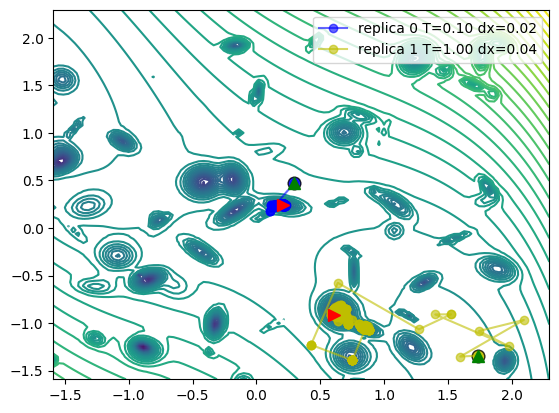

In [103]:
xmin,xmax=np.min(xTraj[:,:,:]),np.max(xTraj[:,:,:])
margin=0.2
x_points = np.linspace(xmin-margin,xmax+margin,100)
y_points = np.linspace(xmin-margin,xmax+margin,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=50)
CS = plt.margins(0.05) # this is not really having much effect 
# rgb=np.random.uniform(size=(nrep,3))
rgb = 'bycm'
for rep in range(nrep):
    CS = plt.plot([X0[0,rep], xTraj[0,rep,0]], [X0[1,rep], xTraj[1,rep,0]],'o',markersize=9,markeredgecolor='k',linestyle='-',alpha=0.6,color=rgb[rep])
    CS = plt.plot(xTraj[0,rep,:], xTraj[1,rep,:], linestyle='-', marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f'%(rep,Temp[rep],maxdr[rep]))
    CS = plt.plot(xTraj[0,rep,0], xTraj[1,rep,0],'^',markersize=9,linestyle='none',color='green')
    CS = plt.plot(xTraj[0,rep,-1], xTraj[1,rep,-1],'>',markersize=9,linestyle='-',color='red') # final position
CS = plt.legend()


In [119]:
from parallel_temper_BH import parallel_temper as ptbh

# example with no exchange 
# its better to equilibrate at this stage 
####  update_freq= 2 or 5  alpha = 1.0

In [167]:
betas=np.linspace(1,0,2)  # large beta is cold 
gap=0.2
Temp = 1/(betas+gap)
Temp

array([0.83333333, 5.        ])

In [206]:
np.random.seed(42)
# Set the initial state of all replicas
nrep = 2                           # Number of replicas
dim = 2                            # Number of dimensions 
X0=np.zeros((dim,nrep))            # rows are the x,y coords in each column replica - capatibility for the way we setup pes
# for rep in range(nrep):
#     X0[:,rep] = 4*np.random.rand(dim)-2.0              # initial x position of each replice

X0=np.array([[1.5,1.5],[1.0,1.0]] )
# Set simulation parameters

nsteps = 100      # Number of MC sweeps 10000
refreq = 0.0    # 0.001       # 0.5 Fraction of the time to attempt replica exchange
Temp = np.array([0.83,5.0])     # Temperature at each replica
maxdr = np.array([1.0,1.0])     # Maximal displacement in each MC step, for each replica

u = pes(X0) # initial potential energy of the particle
u


array([4.53575, 4.53575])

In [207]:
xTraj = ptbh(pes,X0,nrep,nsteps,dim,refreq,Temp,maxdr)

step: 0 Temp: 0.830 acc1: 1.000 acc2: 0.000 rej: 0.000 maxdr: 1.000 dev: 0.500
step: 0 Temp: 5.000 acc1: 0.000 acc2: 0.000 rej: 1.000 maxdr: 1.000 dev: -0.500
step: 5 Temp: 0.830 acc1: 0.333 acc2: 0.000 rej: 0.667 maxdr: 1.000 dev: -0.167
step: 5 Temp: 5.000 acc1: 0.333 acc2: 0.167 rej: 0.500 maxdr: 1.000 dev: -0.000
step: 10 Temp: 0.830 acc1: 0.182 acc2: 0.000 rej: 0.818 maxdr: 0.833 dev: -0.265
step: 10 Temp: 5.000 acc1: 0.364 acc2: 0.182 rej: 0.455 maxdr: 1.000 dev: 0.045
step: 15 Temp: 0.830 acc1: 0.125 acc2: 0.062 rej: 0.812 maxdr: 0.568 dev: -0.178
step: 15 Temp: 5.000 acc1: 0.438 acc2: 0.250 rej: 0.312 maxdr: 1.045 dev: 0.196
step: 20 Temp: 0.830 acc1: 0.143 acc2: 0.048 rej: 0.810 maxdr: 0.391 dev: -0.121
step: 20 Temp: 5.000 acc1: 0.381 acc2: 0.286 rej: 0.333 maxdr: 1.241 dev: 0.207
step: 25 Temp: 0.830 acc1: 0.154 acc2: 0.115 rej: 0.731 maxdr: 0.270 dev: -0.062
step: 25 Temp: 5.000 acc1: 0.308 acc2: 0.269 rej: 0.423 maxdr: 1.448 dev: 0.111
step: 30 Temp: 0.830 acc1: 0.161 acc2

(2, 100, 100)
<class 'numpy.ndarray'>


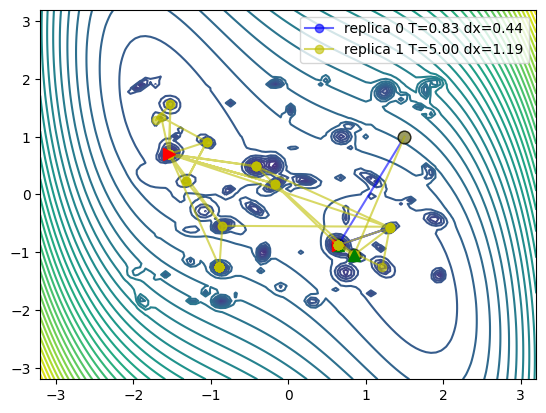

In [208]:
# xmin,xmax=np.min(xTraj[:,:,:]),np.max(xTraj[:,:,:])
xmin,xmax=-3,3
margin=0.2
x_points = np.linspace(xmin-margin,xmax+margin,100)
y_points = np.linspace(xmin-margin,xmax+margin,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=50)
CS = plt.margins(0.05) # this is not really having much effect 
# rgb=np.random.uniform(size=(nrep,3))
rgb = 'bycm'

for rep in range(nrep):
    CS = plt.plot([X0[0,rep],xTraj[0,rep,0]], [X0[1,rep] , xTraj[1,rep,0]],'o',markersize=9,markeredgecolor='k',linestyle='-',alpha=0.6,color=rgb[rep])
    CS = plt.plot(xTraj[0,rep,:],xTraj[1,rep,:],linestyle='-',marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f'%(rep,Temp[rep],maxdr[rep]))
    CS = plt.plot(xTraj[0,rep,0], xTraj[1,rep,0],'^',markersize=9,linestyle='none',color='green')
    CS = plt.plot(xTraj[0,rep,-1], xTraj[1,rep,-1],'>',markersize=9,linestyle='-',color='red')

CS = plt.legend()


# example with  exchange 
#### its better to equilibrate the displacment magnitudes with exchange turned off.
####  also consider that the update frequency  or learning rate alpha can be reduced 
####  update_freq= 10  alpha = 0.1

In [228]:



np.random.seed(42)
# Set the initial state of all replicas
nrep = 2                           # Number of replicas
dim = 2                            # Number of dimensions 
X0=np.zeros((dim,nrep))            # rows are the x,y coords in each column replica - capatibility for the way we setup pes
# for rep in range(nrep):
#     X0[:,rep] = 4*np.random.rand(dim)-2.0              # initial x position of each replice

X0=np.array([[1.5,1.5],[1.0,1.0]] )
# Set simulation parameters

nsteps = 100      # Number of MC sweeps 10000
refreq = 0.5      # 0.001  #  0.5 Fraction of the time to attempt replica exchange
Temp = np.array([0.83,5.0])     # Temperature at each replica
maxdr = np.array([0.43867317, 1.18924646])     # Maximal displacement in each MC step, for each replica

u = pes(X0) # initial potential energy of the particle
u


array([4.53575, 4.53575])

In [229]:
xTraj = ptbh(pes,X0,nrep,nsteps,dim,refreq,Temp,maxdr)

step: 0 Temp: 0.830 acc1: 0.000 acc2: 0.000 rej: 1.000 maxdr: 0.439 dev: -0.022
step: 0 Temp: 5.000 acc1: 1.000 acc2: 0.000 rej: 0.000 maxdr: 1.189 dev: 0.059
exchange at step 1
step: 5 Temp: 0.830 acc1: 0.000 acc2: 0.000 rej: 1.000 maxdr: 0.439 dev: -0.022
step: 5 Temp: 5.000 acc1: 0.333 acc2: 0.167 rej: 0.500 maxdr: 1.189 dev: -0.000
exchange at step 8
step: 10 Temp: 0.830 acc1: 0.091 acc2: 0.000 rej: 0.909 maxdr: 0.417 dev: -0.017
step: 10 Temp: 5.000 acc1: 0.364 acc2: 0.182 rej: 0.455 maxdr: 1.189 dev: 0.005
step: 15 Temp: 0.830 acc1: 0.062 acc2: 0.125 rej: 0.812 maxdr: 0.400 dev: -0.012
step: 15 Temp: 5.000 acc1: 0.375 acc2: 0.250 rej: 0.375 maxdr: 1.195 dev: 0.015
step: 20 Temp: 0.830 acc1: 0.095 acc2: 0.143 rej: 0.762 maxdr: 0.387 dev: -0.010
step: 20 Temp: 5.000 acc1: 0.333 acc2: 0.238 rej: 0.429 maxdr: 1.210 dev: 0.009
step: 25 Temp: 0.830 acc1: 0.154 acc2: 0.154 rej: 0.692 maxdr: 0.377 dev: -0.007
step: 25 Temp: 5.000 acc1: 0.346 acc2: 0.269 rej: 0.385 maxdr: 1.218 dev: 0.014

(2, 100, 100)
<class 'numpy.ndarray'>


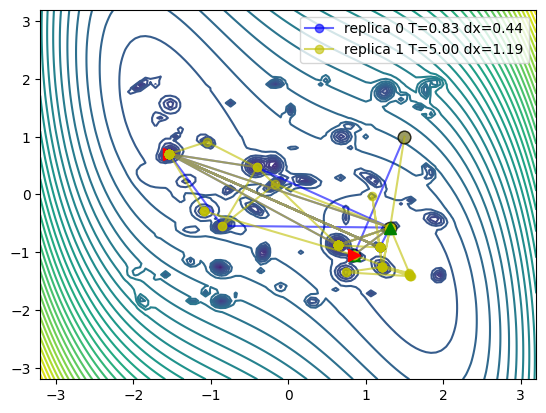

In [223]:
# xmin,xmax=np.min(xTraj[:,:,:]),np.max(xTraj[:,:,:])
xmin,xmax=-3,3
margin=0.2
x_points = np.linspace(xmin-margin,xmax+margin,100)
y_points = np.linspace(xmin-margin,xmax+margin,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=50)
CS = plt.margins(0.05) # this is not really having much effect 
# rgb=np.random.uniform(size=(nrep,3))

rgb = 'bycm'
for rep in range(nrep):
    CS = plt.plot([X0[0,rep],xTraj[0,rep,0]], [X0[1,rep] , xTraj[1,rep,0]],'o',markersize=9,markeredgecolor='k',linestyle='-',alpha=0.6,color=rgb[rep])
    CS = plt.plot(xTraj[0,rep,:],xTraj[1,rep,:],linestyle='-',marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f'%(rep,Temp[rep],maxdr[rep]))
    CS = plt.plot(xTraj[0,rep,0], xTraj[1,rep,0],'^',markersize=9,linestyle='none',color='green')
    CS = plt.plot(xTraj[0,rep,-1], xTraj[1,rep,-1],'>',markersize=9,linestyle='-',color='red')
CS = plt.legend()